In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

In [3]:
dim = 3
N = 500000
NumberofSources = dim
NumberofMixtures = 6

signed_dims = np.array([0,1])
nn_dims = np.array([2])
sparse_dims_list = [np.array([0,1]),np.array([1,2])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
S = generate_uniform_points_in_polytope(V, N)

Text(0.5, 0.98, 'Scatter Plot of Source Components')

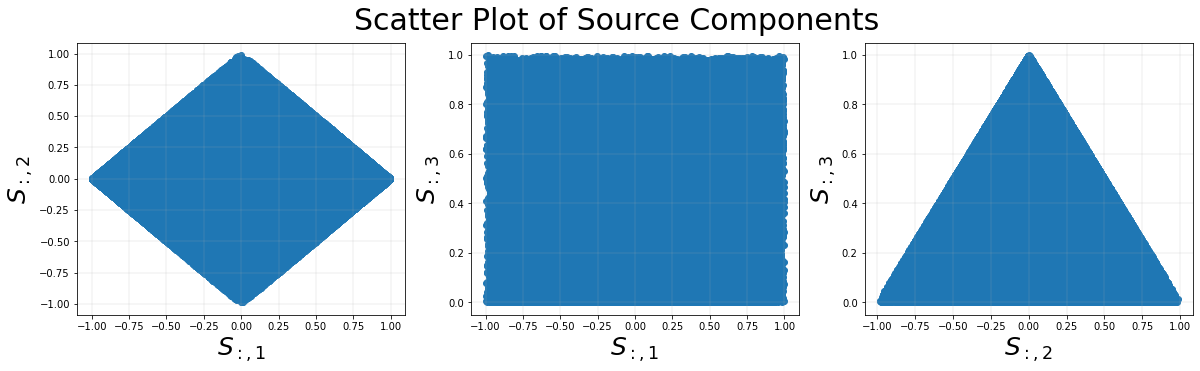

In [4]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.scatter(S[0,:], S[1,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,2}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,2)
plt.scatter(S[0,:], S[2,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,3)
plt.scatter(S[1,:], S[2,:])
plt.xlabel("$S_{:,2}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)

plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
# plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)

In [5]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 24.285138048456147


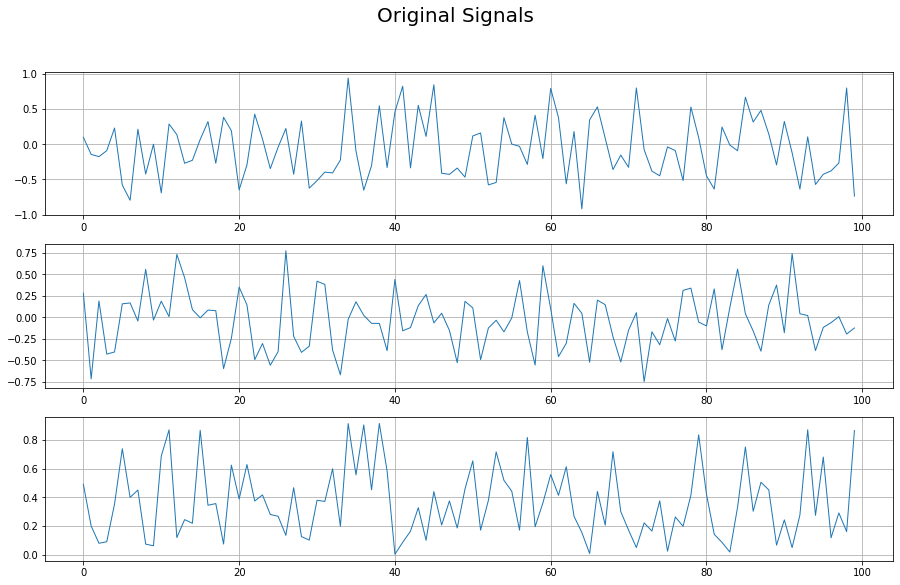

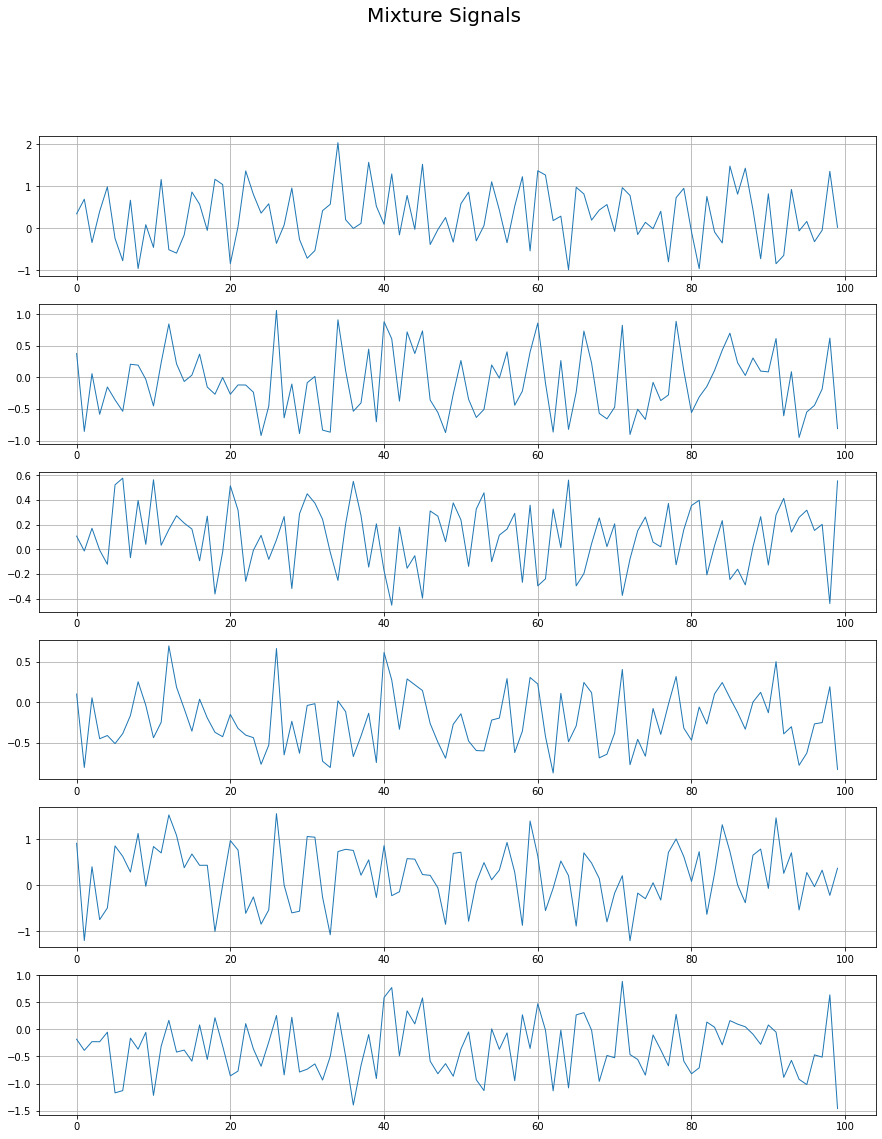

In [6]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

In [7]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-5/10
beta = 50
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 1e-3, lambday = lambday,
                      lambdae = lambdae, beta = beta, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

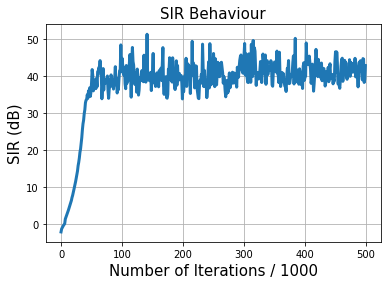

100%|██████████| 500000/500000 [04:55<00:00, 1693.26it/s]


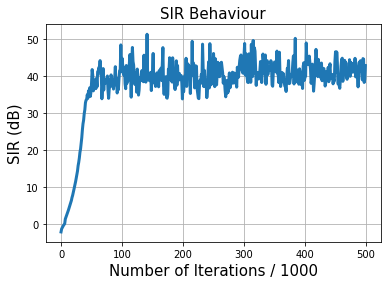

In [8]:
model.fit_batch_general_polytope(X = X, signed_dims = signed_dims, nn_dims = nn_dims,
                                sparse_dims_list = sparse_dims_list,n_epochs = 1, neural_dynamic_iterations = 500,
                                plot_in_jupyter = True, neural_lr_start = 0.1, neural_lr_stop = 1e-10,
                                 debug_iteration_point = debug_iteration_point, 
                                shuffle = True)

In [9]:
model.Be

array([[ 1.64871349e+00, -9.69331151e-07,  1.11239202e-06],
       [-9.69331151e-07,  1.64870736e+00,  7.64304231e-07],
       [ 1.11239202e-06,  7.64304231e-07,  1.64870218e+00]])

In [10]:
model.By

array([[ 4.70685737,  0.01773113,  0.22802711],
       [ 0.01773113,  8.93503829, -0.35413048],
       [ 0.22802711, -0.35413048,  4.97049813]])

In [11]:
x_current = X[:,0]
y = np.zeros(model.s_dim)
W = model.W
Be = model.Be
e = y - W @ x_current
ee = Be @ e
e

array([-0.13654186, -0.25874393, -0.50015514])

In [12]:
np.outer(ee,ee)

array([[0.05067843, 0.09603413, 0.18563451],
       [0.09603413, 0.18198183, 0.3517719 ],
       [0.18563451, 0.3517719 , 0.67997706]])